## Import libaires and MNIST dataset

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
import torch.autograd.profiler as profiler

In [2]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=T)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=T)


#Number of batch
numb_batch = 30

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size = numb_batch)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size = numb_batch)


## Checking the data

In [3]:
len_mnist_train = len(mnist_trainset)
len_mnist_test = len(mnist_testset)
input_size = mnist_trainset[0][0].shape

print("Length of trainset:", len_mnist_train)
print("Length of testset:", len_mnist_test)
print(f"Input size of one image: {input_size}")


Length of trainset: 60000
Length of testset: 10000
Input size of one image: torch.Size([1, 28, 28])


## Define the network (ANN)

There should be two different versions of the ANN:

1. MLP1: Only one hidden layer with a step size of 30, so here we try different number of neurons
2. MLP2: Here we have two layers: One layer is 300 for the first layer and 100 for the second layer. Here we could play around with a stepsize of 50 for the first layer and 20 for the second layer


### MLP-2

In [4]:
class MLP(nn.Module):
    def __init__(self,n_hidden_layer_1,n_hidden_layer_2):
        super(MLP, self).__init__()
        
        #Input will be 28*28 and output will be 10
        self.input_layer = nn.Linear(28*28,n_hidden_layer_1)
        self.hidden_layer_1 = nn.Linear(n_hidden_layer_1,n_hidden_layer_2)
        self.hidden_layer_2 = nn.Linear(n_hidden_layer_2,10)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)  #Here we use the ReLu, it often works fine
        x = self.hidden_layer_1(x)
        x = torch.relu(x)
        x = self.hidden_layer_2(x)
        
        return x

#### Creating several MLP-1

In [5]:
mlp_2_models = []
#Increasing with 30
start_layer_1 = 30
#Increasing with 10
start_layer_2 = 10

for i in range(10):
    #Creating the model
    model = MLP(start_layer_1*i+start_layer_1,start_layer_2*i+start_layer_2)
    #Optimizer and loss
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #criterion = nn.CrossEntropyLoss()
    #Append to list
    mlp_2_models.append(model)
    

## Training

In [6]:
def traning_func(num_epochs, model,file_name):
    
    loss_each_epoch = []
    
    test_model = model

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        running_loss = 0
    
        for images, labels in train_loader:
            #Here we havet to first flatten the image so we go from 28,28 to 784
            images = images.view(images.shape[0],-1)
            #Resetting the gradient
            optimizer.zero_grad()
        
            #Forward propagation
            output = test_model(images)
        
            #Calculate the loss
            loss = criterion(output,labels)
        
            #Backpropagation
            loss.backward()
            optimizer.step()
        
            #Accumelated loss for the whole epoch
            running_loss += loss.item()
        else:
            
            loss_each_epoch.append(running_loss/len(train_loader))
            
    model_filename = f'MLP_2_{30*file_name}_{10*file_name}.pth'
    torch.save(model.state_dict(), model_filename)
            
    return loss_each_epoch


In [2]:
num_epoch = 20

#So loss array should directly correspond to the amount of epoch and the number of different models
loss_array = []

r = 0
for k in mlp_2_models:
    loss_array.append(traning_func(num_epoch,k,r+1))
    
    print("MLP-2 Model with two hidden layers: First: {}, Second: {} is now trained".format(30+30*r,10+10*r))
    r = r +1
        
print("Training is completed")

NameError: name 'mlp_2_models' is not defined

## Testing

In [7]:
def test_func(model): 

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
        
            images = images.view(images.shape[0],-1)

            output = model(images)
        
            _, predicted = torch.max(output.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Accuracy of the network: {} %".format(100*correct//total))
    

## Inference performance

In [8]:
import torch.autograd.profiler as profiler

def inference_func(model):
    with profiler.profile(record_shapes=True,profile_memory=True) as prof:
        with torch.no_grad():
            
            #output = model(test_data)
            test_func(model)

    cpu_time = prof.self_cpu_time_total
    memory_summary = prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10)
    
    print(f"Total CPU Time: {cpu_time*10**-6} seconds")
    print(memory_summary)
  

## All the data for MLP-1

In [9]:
#We can use the below code if we want

#single_data_entry, target = next(iter(test_loader))
#single_data_entry = single_data_entry.view(single_data_entry.shape[0], -1)


for k in range(10):
    
    loaded_model = MLP(30*k+30,10*k+10)  # Create an instance of the model
    loaded_model.load_state_dict(torch.load(f'MLP_2_{30*k+30}_{10*k+10}.pth'))
    
    print(f"Model: MLP-2 with {30*k+30} and {10*k+10} neurons in hidden layers")
    inference_func(loaded_model)
   
    
    print("______________________________________________________________________")


Model: MLP-2 with 30 and 10 neurons in hidden layers
Accuracy of the network: 95 %
Total CPU Time: 1.8650399999999998 seconds
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    aten::empty_strided         1.93%      36.086ms         1.93%      36.086ms       1.775us      30.00 Mb      30.00 Mb         20334  
                                              aten::cat         0.32%       6.020ms         0.32%       6.020ms      18.024us      29.91 Mb      29.91 Mb           334  
                        

Accuracy of the network: 96 %
Total CPU Time: 1.971328 seconds
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    aten::empty_strided         1.89%      37.302ms         1.89%      37.302ms       1.834us      29.99 Mb      29.99 Mb         20334  
                                              aten::cat         0.34%       6.615ms         0.34%       6.615ms      19.805us      29.91 Mb      29.91 Mb           334  
                                              aten::div         3.59%      70.854ms    

Accuracy of the network: 97 %
Total CPU Time: 2.020911 seconds
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    aten::empty_strided         1.79%      36.195ms         1.79%      36.195ms       1.780us      29.98 Mb      29.98 Mb         20334  
                                              aten::cat         0.32%       6.493ms         0.32%       6.493ms      19.440us      29.91 Mb      29.91 Mb           334  
                                              aten::div         3.63%      73.345ms    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


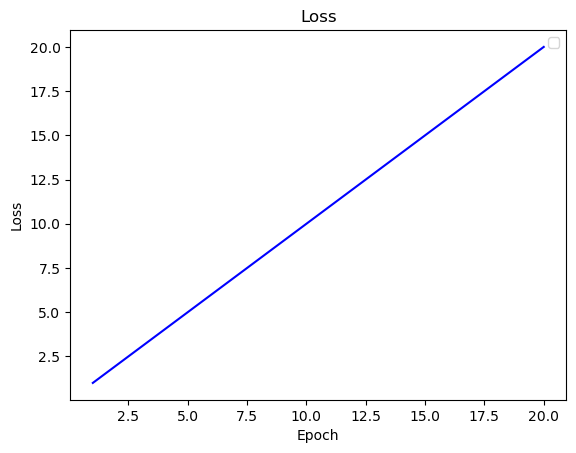

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def plot_loss(numpy_array_data, epo):
    plt.figure()
    plt.plot(range(1,epo+1), numpy_array_data, color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

plot_loss(loss_array[0], 20)
plt.show()

